In [127]:
from utils import *
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.decomposition import PCA

In [128]:
fd_collection = getCollection("team_5_mwdb_phase_2", "fd_collection")

In [129]:
selected_feature_model = "fc_fd"

t = int(input("Enter value of t: "))
if t < 1:
    raise ValueError("t should be a positive integer")

num_layers = int(input("Enter the number of layers: "))
if num_layers < 1:
    raise ValueError("num_layers should be a positive integer")

num_hashes_per_layer = int(input("Enter the number of hashes per layer: "))
if num_hashes_per_layer < 1:
    raise ValueError("num_hashes_per_layer should be a positive integer")

In [130]:
all_images = list(fd_collection.find())
all_images = sorted(all_images, key = lambda x: x["image_id"])

odd_image_ids = [img["image_id"] for img in all_images if img["image_id"] % 2 == 0]

even_image_labels = [img["true_label"] for img in all_images if img["image_id"] % 2 == 0]
odd_image_labels = [img["true_label"] for img in all_images if img["image_id"] % 2 != 0]

feature_vectors = [np.array(img[selected_feature_model]).flatten() for img in all_images]

total_len = len(feature_vectors)
even_feature_vectors = []
odd_feature_vectors = []

for i in range(total_len):
  if i % 2 == 0:
    even_feature_vectors.append(feature_vectors[i])
  else:
    odd_feature_vectors.append(feature_vectors[i])

even_feature_vectors = np.array(even_feature_vectors)
odd_feature_vectors = np.array(odd_feature_vectors)

odd_len = odd_feature_vectors.shape[0]
even_len = even_feature_vectors.shape[0]

In [131]:
query_image_id = int(input("Enter value of query_image_id: "))
if query_image_id < 0:
    raise ValueError("query_image_id should be a positive integer")

num_vectors = even_feature_vectors.shape[0]
vector_dimension = even_feature_vectors.shape[1]

lsh = LSH(even_feature_vectors, num_layers, num_hashes_per_layer)

query_vector = np.array(odd_feature_vectors[(query_image_id // 2)])


similar_images = lsh.find_similar(query_vector, t)

print(f"{t} Most Similar Vectors:")

training_vectors = []
training_labels = []
for image in similar_images:
    img = fd_collection.find_one({"image_id": image*2})
    training_labels.append(img["true_label"])
    training_vectors.append(img[selected_feature_model])
    print(f"Label: {img['true_label']}, {img[selected_feature_model]}")

10 Most Similar Vectors:
Label: 5, [0.4623788595199585, 0.0011552674695849419, -0.36981743574142456, -0.2036924958229065, -0.0009882748126983643, 0.3301119804382324, -0.7115498185157776, -0.46711573004722595, -0.41386187076568604, -0.3488124907016754, 0.5900148153305054, -0.10058745741844177, -0.10812616348266602, -0.6147000789642334, -0.19908009469509125, -0.07992485910654068, -0.11981599032878876, -0.41764718294143677, -0.6283365488052368, -0.3422481417655945, -0.0817180648446083, 0.7590495347976685, -0.6938257813453674, -0.4489600360393524, -0.45218169689178467, -0.12075934559106827, 0.4350382387638092, -0.14924535155296326, 0.15811331570148468, 0.3477158546447754, -0.34741124510765076, -0.2177758514881134, 0.23721426725387573, -0.06809959560632706, -0.238507479429245, -0.20404988527297974, 0.12066644430160522, -0.5871298909187317, 0.30363214015960693, -0.07998495548963547, -0.3448579013347626, 0.1277788132429123, -0.26283401250839233, 0.20805241167545319, 0.012967227026820183, -0.1

In [132]:
print(training_vectors)
print(training_labels)

user_feedback = []

length = len(training_labels)

for i in range(length):
  print(f"Label: {training_labels[i]}, vector: {training_vectors[i]}")
  feedback = input(f"What is the feedback for result {i}? (R+, R, I, I-)")

  match feedback:

    case "R+":
      user_feedback.append(2)

    case "R":
      user_feedback.append(1)

    case "I":
      user_feedback.append(-1)

    case "I-":
      user_feedback.append(-2)

[[0.4623788595199585, 0.0011552674695849419, -0.36981743574142456, -0.2036924958229065, -0.0009882748126983643, 0.3301119804382324, -0.7115498185157776, -0.46711573004722595, -0.41386187076568604, -0.3488124907016754, 0.5900148153305054, -0.10058745741844177, -0.10812616348266602, -0.6147000789642334, -0.19908009469509125, -0.07992485910654068, -0.11981599032878876, -0.41764718294143677, -0.6283365488052368, -0.3422481417655945, -0.0817180648446083, 0.7590495347976685, -0.6938257813453674, -0.4489600360393524, -0.45218169689178467, -0.12075934559106827, 0.4350382387638092, -0.14924535155296326, 0.15811331570148468, 0.3477158546447754, -0.34741124510765076, -0.2177758514881134, 0.23721426725387573, -0.06809959560632706, -0.238507479429245, -0.20404988527297974, 0.12066644430160522, -0.5871298909187317, 0.30363214015960693, -0.07998495548963547, -0.3448579013347626, 0.1277788132429123, -0.26283401250839233, 0.20805241167545319, 0.012967227026820183, -0.18457971513271332, -0.4096693098545

In [133]:
print(user_feedback)

[2, 2, 2, 2, 2, 2, 2, 2, 2]


In [134]:
relevant = []
relevant_labels = []
irrelevant = []
irrelevant_labels = []
for i in range(len(user_feedback)):
    if user_feedback[i] > 0:
        relevant.append(np.array(training_vectors[i]))
        relevant_labels.append(1)
        more_relevant = fd_collection.find({"true_label": training_labels[i], "image_id": {"$mod": [2,0]}})
        more_relevant_vectors = [np.array(image[selected_feature_model]).flatten() for image in more_relevant]
        random.shuffle(more_relevant_vectors)
        if len(more_relevant_vectors)>=20:
            more_relevant_vectors = more_relevant_vectors[:20]
            relevant.extend(more_relevant_vectors)
            relevant_labels.extend([1]*20)
            continue
        more_relevant_vectors = more_relevant_vectors[:10]
        relevant.extend(more_relevant_vectors)
        relevant_labels.extend([1]*10)
            
    else:
        irrelevant.append(np.array(training_vectors[i]))
        irrelevant_labels.append(0)
        more_irrelevant = fd_collection.find({"true_label": training_labels[i], "image_id": {"$mod": [2,0]}})
        more_irrelevant_vectors = [np.array(image[selected_feature_model]).flatten() for image in more_irrelevant]
        random.shuffle(more_irrelevant_vectors)
        if len(more_relevant_vectors)>20:
            more_irrelevant_vectors = more_irrelevant_vectors[:20]
            irrelevant_labels.extend([0]*20)
            continue
        irrelevant.extend(more_irrelevant_vectors)
        irrelevant_labels.extend([0]*len(more_irrelevant_vectors))

if len(irrelevant) == 0:
    more_irrelevant = fd_collection.find({"true_label": training_labels[i], "image_id": {"$mod": [2,0]}})
    more_irrelevant_vectors = [np.array(image[selected_feature_model]).flatten() for image in more_irrelevant]
    irrelevant = more_irrelevant_vectors[:10]
    irrelevant_labels = [0]*10


relevant.extend(irrelevant)
X_train = relevant
relevant_labels.extend(irrelevant_labels)
y_train = relevant_labels
X_test_relevant = fd_collection.find({"true_label": odd_image_labels[query_image_id//2], "image_id": {"$mod": [2,1]}})
X_test_imageid = [image["image_id"] for image in X_test_relevant]
X_test = [np.array(image[selected_feature_model]).flatten() for image in X_test_relevant]
y_test = [1]*len(X_test)
irrelevant_images = fd_collection.find({"true_label": {"$ne": odd_image_labels[query_image_id//2]}, "image_id": {"$mod": [2,1]}})
X_test_irrelevant = [np.array(image[selected_feature_model]).flatten() for image in irrelevant_images]
irrelevant_images = fd_collection.find({"true_label": {"$ne": odd_image_labels[query_image_id//2]}, "image_id": {"$mod": [2,1]}})
irrelevant_imageids = [image["image_id"] for image in irrelevant_images]
X_test_imageid.extend(irrelevant_imageids)

y_test_irrelevant = [0]*len(X_test_irrelevant)
X_test.extend(X_test_irrelevant)
y_test.extend(y_test_irrelevant)

print(X_test_imageid)


[1923, 1925, 1927, 1929, 1931, 1933, 1935, 1937, 1939, 1941, 1943, 1945, 1947, 1949, 1951, 1953, 1955, 1957, 1959, 1961, 1963, 1965, 1967, 1969, 1971, 1973, 1975, 1977, 1979, 1981, 1983, 1985, 1987, 1989, 1991, 1993, 1995, 1997, 1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019, 2021, 2023, 2025, 2027, 2029, 2031, 2033, 2035, 2037, 2039, 2041, 2043, 2045, 2047, 2049, 2051, 2053, 2055, 2057, 2059, 2061, 2063, 2065, 2067, 2069, 2071, 2073, 2075, 2077, 2079, 2081, 2083, 2085, 2087, 2089, 2091, 2093, 2095, 2097, 2099, 2101, 2103, 2105, 2107, 2109, 2111, 2113, 2115, 2117, 2119, 2121, 2123, 2125, 2127, 2129, 2131, 2133, 2135, 2137, 2139, 2141, 2143, 2145, 2147, 2149, 2151, 2153, 2155, 2157, 2159, 2161, 2163, 2165, 2167, 2169, 2171, 2173, 2175, 2177, 2179, 2181, 2183, 2185, 2187, 2189, 2191, 2193, 2195, 2197, 2199, 2201, 2203, 2205, 2207, 2209, 2211, 2213, 2215, 2217, 2219, 2221, 2223, 2225, 2227, 2229, 2231, 2233, 2235, 2237, 2239, 2241, 2243, 2245, 2247, 2249, 2251, 2253, 225

In [135]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Initialize SVM model
svm_model = svm.SVC(kernel='linear')

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
label = []
similar_images = []
for i in range(len(y_pred)):
    if y_pred[i] == 1 and len(label)<10:
        image = fd_collection.find_one({"image_id": X_test_imageid[i]})
        label.append(image["true_label"])
        similar_images.append(X_test_imageid[i])
        print(f"Label: {image['true_label']}, Image ID: {X_test_imageid[i]}")


# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy on the test set: {accuracy}")


Label: 5, Image ID: 1923
Label: 5, Image ID: 1925
Label: 5, Image ID: 1929
Label: 5, Image ID: 1931
Label: 5, Image ID: 1933
Label: 5, Image ID: 1935
Label: 5, Image ID: 1937
Label: 5, Image ID: 1939
Label: 5, Image ID: 1941
Label: 5, Image ID: 1943


Query Image


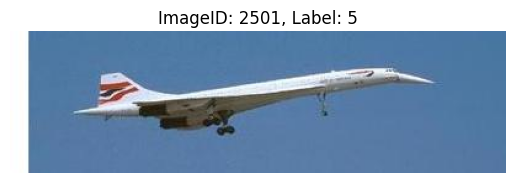

10 similar images after Relevance Feedback


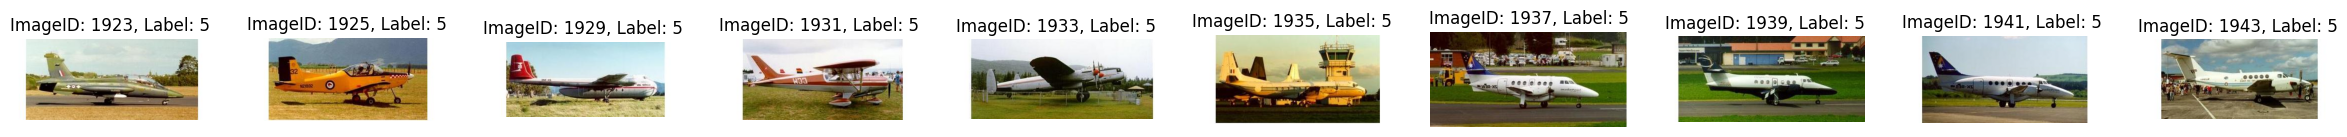

In [136]:
dataset = loadDataset(Caltech101)

print("Query Image")
query_img, query_label = dataset[query_image_id]
plt.imshow(transforms.ToPILImage()(dataset[query_image_id][0]))
plt.title(f"ImageID: {query_image_id}, Label: {query_label}")
plt.axis("off")
plt.show()


print(f"{len(similar_images)} similar images after Relevance Feedback")

fig, axs = plt.subplots(1, len(similar_images), figsize=(30, 8))
for idx, img_id in enumerate(similar_images):
    cur_img, cur_label = dataset[img_id]
    axs[idx].imshow(transforms.ToPILImage()(cur_img))
    axs[idx].set_title(f"ImageID: {img_id}, Label: {cur_label}")
    axs[idx].axis("off")
plt.show()